In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vikra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [5]:
captions= readTextFile("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
#len(captions.split("\n"))
captions=captions.split('\n')[:-1]


In [6]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [7]:
#Dictionary to map each image 

In [8]:
descriptions= {} #dictionary

for x in captions:
    first,second= x.split('\t')
    img_name= first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
            descriptions[img_name]=[]
    descriptions[img_name].append(second)


In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

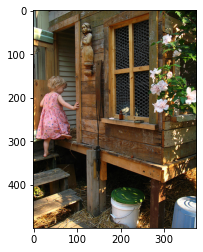

In [10]:
IMG_PATH="Flickr_Data/Images/"

import cv2
img =cv2.imread(IMG_PATH + "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.show()


In [11]:
#DATA CLEANING

In [12]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence= sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence =" ".join(sentence)
    return sentence

In [13]:
clean_text("A cat is siiting over this THAS THAT WAS IS below 1234")

'cat is siiting over this thas that was is below'

In [14]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
# clean all captions 

for key,val in descriptions.items():
    for i in range(len(val)):
        val[i] = clean_text(val[i])

In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
# Write the data to text file
with open("descriptions_2.txt","w") as f:
    f.write(str(descriptions))

In [18]:
descriptions = None
with open("descriptions_2.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


In [20]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [21]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [22]:
# Filter Words from the Vocab according to certain threshold frequncy

In [23]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [24]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [25]:
print(len(total_words))

1845


In [26]:
# prpeare TRAIN/TEST DATA

In [27]:
train_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [28]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [29]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [30]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [31]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [32]:
#Transfer Learning
#Images --> Features
#Text ---> Features

In [33]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [34]:
model_new = Model(model.input,model.layers[-2].output)

In [35]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalisation
    
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


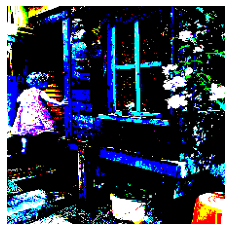

In [36]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [37]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [38]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154468, 0.1707591 , 0.292768  , ..., 0.05094025, 0.31319624,
       0.86007285], dtype=float32)

In [39]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [40]:
!mkdir saved

A subdirectory or file saved already exists.


In [41]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [42]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 204.06522369384766


In [43]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [44]:
# DATA PREPROCEESING FOR CAPTIONS

In [45]:
# Vocab
len(total_words)

1845

In [46]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [47]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [48]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [49]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [50]:
#DATA LOADER GENERATOR

In [51]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [52]:
#word embeddings

In [53]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [54]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [55]:
f.close()

In [56]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [57]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [58]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [59]:
#embedding_matrix[1847]

In [60]:
#MODEL ARCHITECTURE

In [74]:
encoding_test.keys()

dict_keys(['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0', '3482062809_3b694322c4', '1167669558_87a8a467d6', '2847615962_c330bded6e', '3344233740_c010378da7', '2435685480_a79d42e564', '3110649716_c17e14670e', '2511019188_ca71775f2d', '2521770311_3086ca90de', '2723477522_d89f5ac62b', '2218609886_892dcd6915', '3745451546_fc8ec70cbd', '2844018783_524b08e5aa', '3100251515_c68027cc22', '2207244634_1db1a1890b', '2943023421_e297f05e11', '3286822339_5535af6b93', '2479652566_8f9fac8af5', '1394368714_3bc7c19969', '872622575_ba1d3632cc', '2309860995_c2e2a0feeb', '241347204_007d83e252', '3502343542_f9b46688e5', '757332692_6866ae545c', '2748729903_3c7c920c4d', '494792770_2c5f767ac0', '3213992947_3f3f967a9f', '2295750198_6d152d7ceb', '2358898017_24496b80e8', '3222055946_45f7293bb2', '444481722_690d0cadcf'

In [75]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [76]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [77]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [78]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [79]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [80]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [81]:
#Training of Model

In [82]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)#number_pics_per_batch


In [63]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')

In [142]:
model = load_model("model_9.h5")

In [121]:
#predictions

In [122]:
def predict_caption(photo):
    
    in_text = "startseq"
    max_len=35
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [123]:
etv =[]
print(type(encoding_test))
etv= list(encoding_test.keys())
print(etv)
#print(list(encoding_test.keys()))
#print(list(encoding_test.keys()))

<class 'dict'>
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0', '3482062809_3b694322c4', '1167669558_87a8a467d6', '2847615962_c330bded6e', '3344233740_c010378da7', '2435685480_a79d42e564', '3110649716_c17e14670e', '2511019188_ca71775f2d', '2521770311_3086ca90de', '2723477522_d89f5ac62b', '2218609886_892dcd6915', '3745451546_fc8ec70cbd', '2844018783_524b08e5aa', '3100251515_c68027cc22', '2207244634_1db1a1890b', '2943023421_e297f05e11', '3286822339_5535af6b93', '2479652566_8f9fac8af5', '1394368714_3bc7c19969', '872622575_ba1d3632cc', '2309860995_c2e2a0feeb', '241347204_007d83e252', '3502343542_f9b46688e5', '757332692_6866ae545c', '2748729903_3c7c920c4d', '494792770_2c5f767ac0', '3213992947_3f3f967a9f', '2295750198_6d152d7ceb', '2358898017_24496b80e8', '3222055946_45f7293bb2', '444481722_690d0c

In [124]:
d = {
       "class" : 8 ,
       "id"  : 123,                # dictionary in form of "key : value" pair
       "name"  : "jagannath"
    }
    
print (d)
con_list = list(d) # list elements are the keys in dictionary
print (con_list)

{'class': 8, 'id': 123, 'name': 'jagannath'}
['class', 'id', 'name']


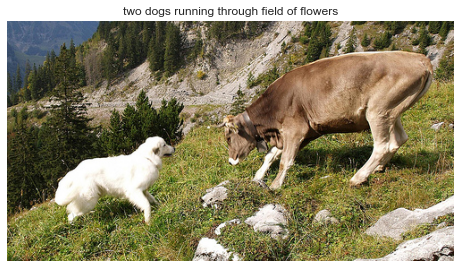

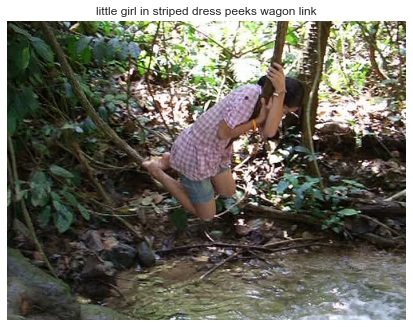

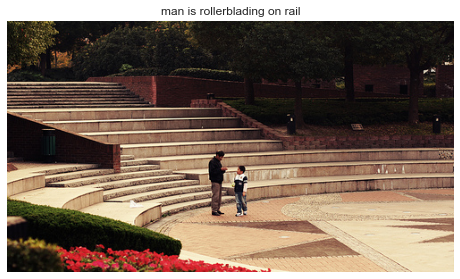

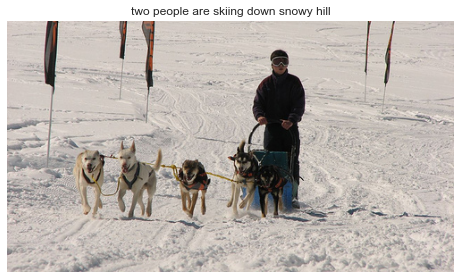

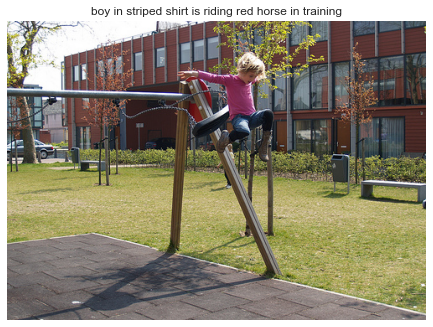

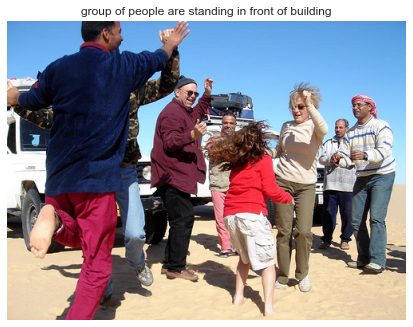

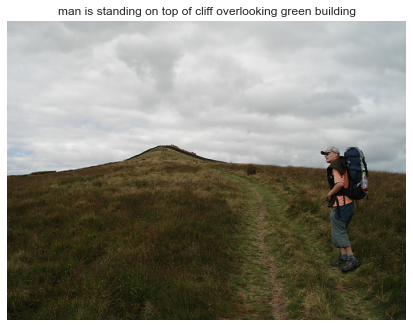

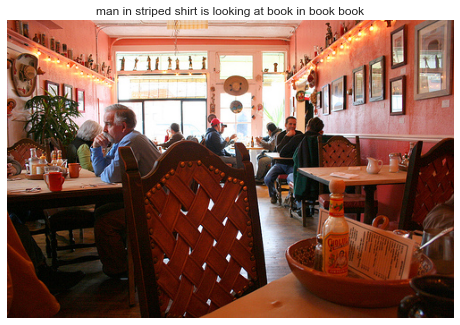

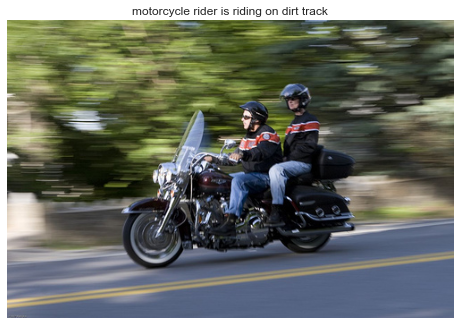

In [140]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [91]:
from keras.preprocessing import image as image_helper

In [126]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
captions  = readTextFile("Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

test_file = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test_images = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
actual_caption = []
for image in test_images:
  temp_caption = []
  for caption in descriptions[image]:
    temp_caption.append(caption.split(' '))
  actual_caption.append(temp_caption)

model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model_new = Model(model.input,model.layers[-2].output)

def preprocess_img(img):
    img = image_helper.load_img(img,target_size=(224,224))
    img = image_helper.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_resnet.predict(img)
    
    feature_vector = feature_vector.reshape(1,feature_vector.shape[1])
    #print(feature_vector.shape)
    return feature_vector

IMG_PATH = "Flickr_Data/Images"
#encoding_test = {}

#for ix,img_id in enumerate(test_images):
    #img_path = IMG_PATH+"/"+img_id+".jpg"
    #encoding_test[img_id] = encode_image(img_path)
    #if ix%100==0:
     #   print("Test Encoding in Progress Time step %d "%ix)

for i in range(len(test_images)):
    image = encoding_test[test[i]].reshape((1,2048))
    caption = predict_caption(image)
    predicted_caption.append(caption.split(' '));

print('Cumulative 1-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0, 0, 0)))
print('Cumulative 2-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % corpus_bleu(actual_caption, predicted_caption,weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25)))

In [138]:
model = load_model("model_9.h5")

In [139]:
from nltk.translate.bleu_score import corpus_bleu
predicted_caption = []
for i in range(len(test_images)):
    print(test_images[i])
    image = encoding_test[test_images[i]].reshape((1,2048))
    caption = predict_caption(image)
    predicted_caption.append(caption.split(' '))
    print(len(predicted_caption))

print('Cumulative 1-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0, 0, 0)))
print('Cumulative 2-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % corpus_bleu(actual_caption, predicted_caption,weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25)))

3385593926_d3e9c21170
1
2677656448_6b7e7702af
2
311146855_0b65fdb169
3
1258913059_07c613f7ff
4
241347760_d44c8d3a01
5
2654514044_a70a6e2c21
6
2339106348_2df90aa6a9
7
256085101_2c2617c5d0
8
280706862_14c30d734a
9
3072172967_630e9c69d0
10
3482062809_3b694322c4
11
1167669558_87a8a467d6
12
2847615962_c330bded6e
13
3344233740_c010378da7
14
2435685480_a79d42e564
15
3110649716_c17e14670e
16
2511019188_ca71775f2d
17
2521770311_3086ca90de
18
2723477522_d89f5ac62b
19
2218609886_892dcd6915
20
3745451546_fc8ec70cbd
21
2844018783_524b08e5aa
22
3100251515_c68027cc22
23
2207244634_1db1a1890b
24
2943023421_e297f05e11
25
3286822339_5535af6b93
26
2479652566_8f9fac8af5
27
1394368714_3bc7c19969
28
872622575_ba1d3632cc
29
2309860995_c2e2a0feeb
30
241347204_007d83e252
31
3502343542_f9b46688e5
32
757332692_6866ae545c
33
2748729903_3c7c920c4d
34
494792770_2c5f767ac0
35
3213992947_3f3f967a9f
36
2295750198_6d152d7ceb
37
2358898017_24496b80e8
38
3222055946_45f7293bb2
39
444481722_690d0cadcf
40
2647049174_0fb47ce

325
512101751_05a6d93e19
326
2317714088_bcd081f926
327
3275704430_a75828048f
328
2518508760_68d8df7365
329
3254817653_632e840423
330
3113322995_13781860f2
331
2103568100_5d018c495b
332
3518126579_e70e0cbb2b
333
2192131110_8a40e7c028
334
2581066814_179d28f306
335
480505313_2dc686e5db
336
1056338697_4f7d7ce270
337
532457586_bddfc5251d
338
3471841031_a949645ba8
339
3295680663_af21ea648b
340
415793623_6c1225ae27
341
2666205903_8d287669e1
342
3323988406_e3c8fce690
343
3347666612_659e6e2207
344
3439382048_d2e23b2b4c
345
2522297487_57edf117f7
346
3003691049_f4363c2d5c
347
2472980433_210ec62874
348
2307118114_c258e3a47e
349
2410320522_d967f0b75c
350
1408958345_68eea9a4e4
351
498444334_a680d318a1
352
3596131692_91b8a05606
353
2208310655_a3d83080c5
354
2340206885_58754a799a
355
2968182121_b3b491df85
356
3514019869_7de4ece2a5
357
2162564553_96de62c7e6
358
766099402_cdda6964f0
359
3593392955_a4125087f6
360
1472230829_803818a383
361
2774554310_007e980a90
362
2289068031_fe26990183
363
3411393875_a9f

645
3602838407_bf13e49243
646
2984174290_a915748d77
647
424779662_568f9606d0
648
2431832075_00aa1a4457
649
624742559_ff467d8ebc
650
3157847991_463e006a28
651
2893374123_087f98d58a
652
3359551687_68f2f0212a
653
3070031806_3d587c2a66
654
2480850054_de3433b54a
655
3216926094_bc975e84b9
656
3449114979_6cdc3e8da8
657
2543589122_ec3e55f434
658
3530843182_35af2c821c
659
3472364264_dbde5a8d0a
660
3715469645_6d1dc019b3
661
2196107384_361d73a170
662
1561658940_a947f2446a
663
3655074079_7df3812bc5
664
3004823335_9b82cbd8a7
665
2495931537_9b8d4474b6
666
293881927_ac62900fd4
667
3162045919_c2decbb69b
668
505929313_7668f021ab
669
3244470342_c08f6bb17e
670
3655964639_21e76383d0
671
3718964174_cb2dc1615e
672
3388330419_85d72f7cda
673
2128119486_4407061c40
674
917574521_74fab68514
675
400851260_5911898657
676
270816949_ffad112278
677
421730441_6b2267fd31
678
429851331_b248ca01cd
679
241345905_5826a72da1
680
2102360862_264452db8e
681
3051384385_c5c850c1f8
682
3500136982_bf7a85531e
683
416788726_5b4eb146

968
3564312955_716e86c48b
969
3238951136_2a99f1a1a8
970
3595643050_d312e4b652
971
3139876823_859c7d7c23
972
3473264983_67917a931f
973
2994179598_a45c2732b5
974
491405109_798222cfd0
975
3115174046_9e96b9ce47
976
3631986552_944ea208fc
977
3350786891_6d39b234e9
978
3062173277_bfb5ef4c45
979
3108197858_441ff38565
980
1224851143_33bcdd299c
981
3458559770_12cf9f134e
982
3425835357_204e620a66
983
3214885227_2be09e7cfb
984
2854207034_1f00555703
985
2167644298_100ca79f54
986
241346971_c100650320
987
1386964743_9e80d96b05
988
3397220683_4aca010f86
989
2473791980_805c819bd4
990
241345844_69e1c22464
991
3256043809_47258e0b3e
992
2351479551_e8820a1ff3
993
3514179514_cbc3371b92
994
1119015538_e8e796281e
995
3727752439_907795603b
996
3430607596_7e4f74e3ff
997
3259666643_ae49524c81
998
2623930900_b9df917b82
999
3490736665_38710f4b91
1000
Cumulative 1-gram: 0.404231
Cumulative 2-gram: 0.228127
Cumulative 3-gram: 0.132630
Cumulative 4-gram: 0.071831
